In [5]:
process.env.TAVILY_API_KEY = "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";

import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";
import { DynamicStructuredTool } from "@langchain/core/tools";
import { z } from "zod";

const tavilyTool = new TavilySearchResults();

const scrapeWebpage = new DynamicStructuredTool({
  name: "scrape_webpage",
  description: "Scrape the contents of a webpage.",
  schema: z.object({
    url: z.string(),
  }),
  func: async ({ url }) => {
    const loader = new CheerioWebBaseLoader(url);
    const docs = await loader.load();
    const formattedDocs = docs.map(
      (doc) =>
        `<Document name="${doc.metadata?.title}">\n${doc.pageContent}\n</Document>`,
    );
    return formattedDocs.join("\n\n");
  },
});

In [6]:
require("esm-hook"); // Only for running this in TSLab in Jupyter. See: https://github.com/yunabe/tslab/issues/72
import { createCanvas } from "canvas";
import * as d3 from "d3";
import * as tslab from "tslab";
import * as fs from "fs/promises";
import * as path from "path";

const WORKING_DIRECTORY = "./temp";
fs.mkdir(WORKING_DIRECTORY, { recursive: true });

const createOutlineTool = new DynamicStructuredTool({
  name: "create_outline",
  description: "Create and save an outline.",
  schema: z.object({
    points: z
      .array(z.string())
      .nonempty("List of main points or sections must not be empty."),
    file_name: z.string(),
  }),
  func: async ({ points, file_name }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name);
    const data = points
      .map((point, index) => `${index + 1}. ${point}\n`)
      .join("");
    await fs.writeFile(filePath, data);
    return `Outline saved to ${file_name}`;
  },
});

const readDocumentTool = new DynamicStructuredTool({
  name: "read_document",
  description: "Read the specified document.",
  schema: z.object({
    file_name: z.string(),
    start: z.number().optional(),
    end: z.number().optional(),
  }),
  func: async ({ file_name, start, end }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name);
    const data = await fs.readFile(filePath, "utf-8");
    const lines = data.split("\n");
    return lines.slice(start ?? 0, end).join("\n");
  },
});

const writeDocumentTool = new DynamicStructuredTool({
  name: "write_document",
  description: "Create and save a text document.",
  schema: z.object({
    content: z.string(),
    file_name: z.string(),
  }),
  func: async ({ content, file_name }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name);
    await fs.writeFile(filePath, content);
    return `Document saved to ${file_name}`;
  },
});

const editDocumentTool = new DynamicStructuredTool({
  name: "edit_document",
  description: "Edit a document by inserting text at specific line numbers.",
  schema: z.object({
    file_name: z.string(),
    inserts: z.record(z.number(), z.string()),
  }),
  func: async ({ file_name, inserts }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name);
    const data = await fs.readFile(filePath, "utf-8");
    let lines = data.split("\n");

    const sortedInserts = Object.entries(inserts).sort(
      ([a], [b]) => parseInt(a) - parseInt(b),
    );

    for (const [line_number_str, text] of sortedInserts) {
      const line_number = parseInt(line_number_str);
      if (1 <= line_number && line_number <= lines.length + 1) {
        lines.splice(line_number - 1, 0, text);
      } else {
        return `Error: Line number ${line_number} is out of range.`;
      }
    }

    await fs.writeFile(filePath, lines.join("\n"));
    return `Document edited and saved to ${file_name}`;
  },
});

const chartTool = new DynamicStructuredTool({
  name: "generate_bar_chart",
  description:
    "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
  schema: z.object({
    data: z
      .object({
        label: z.string(),
        value: z.number(),
      })
      .array(),
  }),
  func: async ({ data }) => {
    const width = 500;
    const height = 500;
    const margin = { top: 20, right: 30, bottom: 30, left: 40 };

    const canvas = createCanvas(width, height);
    const ctx = canvas.getContext("2d");

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1);

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value) ?? 0])
      .nice()
      .range([height - margin.bottom, margin.top]);

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ];

    data.forEach((d, idx) => {
      ctx.fillStyle = colorPalette[idx % colorPalette.length];
      ctx.fillRect(
        x(d.label) ?? 0,
        y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value),
      );
    });

    ctx.beginPath();
    ctx.strokeStyle = "black";
    ctx.moveTo(margin.left, height - margin.bottom);
    ctx.lineTo(width - margin.right, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "center";
    ctx.textBaseline = "top";
    x.domain().forEach((d) => {
      const xCoord = (x(d) ?? 0) + x.bandwidth() / 2;
      ctx.fillText(d, xCoord, height - margin.bottom + 6);
    });

    ctx.beginPath();
    ctx.moveTo(margin.left, height - margin.top);
    ctx.lineTo(margin.left, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "right";
    ctx.textBaseline = "middle";
    const ticks = y.ticks();
    ticks.forEach((d) => {
      const yCoord = y(d); // height - margin.bottom - y(d);
      ctx.moveTo(margin.left, yCoord);
      ctx.lineTo(margin.left - 6, yCoord);
      ctx.stroke();
      ctx.fillText(d.toString(), margin.left - 8, yCoord);
    });

    tslab.display.png(canvas.toBuffer());
    return "Chart has been generated and displayed to the user!";
  },
});

In [7]:
// Example invocation
await writeDocumentTool.invoke({
  content: "Hello from LangGraph!",
  file_name: "hello.txt",
});


Document saved to hello.txt


In [8]:

await readDocumentTool.invoke({ file_name: "hello.txt" });

Hello from LangGraph!


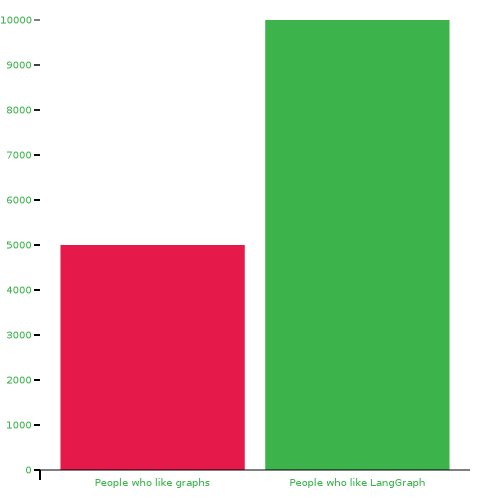

Chart has been generated and displayed to the user!


In [9]:
await chartTool.invoke({
  data: [
    { label: "People who like graphs", value: 5000 },
    {
      label: "People who like LangGraph",
      value: 10000,
    },
  ],
});

In [ ]:
require("esm-hook")

import { chartTool } from './tools/DocumentWritingTeam/chartTool.js'
import { readDocumentTool } from './tools/DocumentWritingTeam/readDocumentTool.js'
import { writeDocumentTool } from './tools/DocumentWritingTeam/writeDocumentTool.js'

async function main() {
  await writeDocumentTool.invoke({
    content: 'Hello from LangGraph!',
    file_name: 'hello.txt'
  })

  await readDocumentTool.invoke({ file_name: 'hello.txt' })

  await chartTool.invoke({
    data: [
      { label: 'People who like graphs', value: 5000 },
      {
        label: 'People who like LangGraph',
        value: 10000
      }
    ]
  })
}
main()


unexpected error: TypeError: Cannot read properties of undefined (reading 'parent')
    at getDeclarationContainer (C:\Users\Administrador\Desktop\Rocketseat\IA\langgraph_hierachical_agents\node_modules\@tslab\typescript-for-tslab\lib\typescript.js:52993:9)
    at determineIfDeclarationIsVisible (C:\Users\Administrador\Desktop\Rocketseat\IA\langgraph_hierachical_agents\node_modules\@tslab\typescript-for-tslab\lib\typescript.js:52822:29)
    at Object.isDeclarationVisible (C:\Users\Administrador\Desktop\Rocketseat\IA\langgraph_hierachical_agents\node_modules\@tslab\typescript-for-tslab\lib\typescript.js:52795:31)
    at getBindingNameVisible (C:\Users\Administrador\Desktop\Rocketseat\IA\langgraph_hierachical_agents\node_modules\@tslab\typescript-for-tslab\lib\typescript.js:107624:25)
    at forEach (C:\Users\Administrador\Desktop\Rocketseat\IA\langgraph_hierachical_agents\node_modules\@tslab\typescript-for-tslab\lib\typescript.js:59:24)
    at transformVariableStatement (C:\Users\Admini